In [1]:
## import the required package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## Data Description

The data contains the crimial history jail and prison time, demographics and COMPAS risk scores for defendants from Broward County from 2013 to 2014. The dataset we are using is compas-scores-two-years.csv.

In [2]:
## Read the file
df = pd.read_csv("content/compas-scores-two-years.csv")

## Filter the data
df = df[(df["race"] == "African-American") | (df["race"] == "Caucasian")]

## Change the race entry
df["race"] = np.where(df["race"] == "African-American", 0, 1)

## We drop attributes that is clearly independent with the two_year_recid, ie. name, id, r_case_number, c_case_number,
## as well as the attribute with all NaN value
## as well as the duplicate columns
df.drop(["id", "name", "first", "last", "r_case_number", "c_case_number",
         "violent_recid",
         "decile_score.1", "priors_count.1"],
        axis = 1, inplace=True)

In [3]:
## We drop the column with the number of NaN value exceed 1000
df.drop(["vr_charge_desc", "vr_offense_date",
        "vr_charge_degree", "vr_case_number", "c_arrest_date",
        "c_arrest_date", "r_jail_out", "r_jail_in", "r_days_from_arrest",
        "r_charge_desc", "r_charge_degree", "r_offense_date"],
        axis = 1, inplace=True)

## Remove the rows with NaN
df.dropna(inplace=True)

## we also drop the columns represent the date
df.drop(['compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out',
         'c_offense_date', 'screening_date', 'v_screening_date',
         'in_custody', 'out_custody', 'days_b_screening_arrest'],
        axis = 1, inplace=True)

## We drop the somehow repeated attribute, age_cat, score_text, v_score_text
df.drop(['age_cat', 'score_text', 'v_score_text', 'is_recid', "v_decile_score"],
        axis = 1, inplace=True)

## Set sex into 0 or 1, c_charge_degree into 0 or 1
df["sex"] = np.where(df["sex"] == "Male", 0, 1)
df["c_charge_degree"] = np.where(df["c_charge_degree"] == "M", 0, 1)

## Drop the column with only 1 input or too many category
df.drop(['type_of_assessment', 'v_type_of_assessment', 'c_charge_desc'],
        axis = 1, inplace=True)

In [4]:
df.head(5)

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_violent_recid,start,end,event,two_year_recid
1,0,34,0,0,3,0,0,0,1.0,1,1,9,159,1,1
2,0,24,0,0,4,0,1,4,1.0,1,0,0,63,0,1
6,0,41,1,0,6,0,0,14,1.0,1,0,5,40,1,1
8,1,39,1,0,1,0,0,0,1.0,0,0,2,747,0,0
9,0,21,1,0,3,0,0,1,308.0,1,1,0,428,1,1


## Baseline Model

We use a Boosting model

In [5]:
scaler = StandardScaler()
X, y = df.drop("two_year_recid", axis = 1, inplace = False), df.two_year_recid
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=5243)

baseline = LogisticRegression(random_state=5243,max_iter=1000)

baseline.fit(X_train, y_train)
preds = baseline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
accuracy_base = sum(y_test == preds)/len(y_test)

print("Baseline RMSE: %f" % (rmse))
print("Baseline Accuracy: %f" % (accuracy_base))

Baseline RMSE: 0.219308
Baseline Accuracy: 0.951904


## Paper 1: Handling Conditional Discrimination

This paper handle with discrimination introduced by sensitive parameter, here "race".

### Background

The bias that caused by discrimination can be distribute to two part:
- discrimination caused by the sensitive attribute itself $D_{bad}$
- the discrimination caused by the attributes that are correlated to the sensitive attribute $D_{expl}$.

*Notice* : the attribute that are correlated to the sensitive attribute and also gives some objective information to the label y is called **explanatory attribute**.

In summary, $D_{all}=D_{bad}+D_{expl}$.

### Objective of the paper

- minimize the absolute value of $D_{bad}$
- keeping the accuracy as high as possible

### Method

To be discrimination free, we should control:
- $P_c(+|e_i, race = 0) = P_c(+|e_i, race = 1)$, where $e_i$ is the explanatory attribute and $P(+)=P(y=+1)$
- $P_c(+|e_i) = P_c^\star(+|e_i)$, where $P_c^\star(+|e_i):=\frac{P_c(+|e_i, race=1)+P_c(+|e_i, race=0)}{2}$

To achieve it, the paper introduced two methods: Local Massaging and Local Preferential Sampling.

###  *Local Massaging*

Modify the value of y until $P_c'(+|e_i, race = 0)=P_c'(+|e_i, race = 1)=P_c^\star(+|e_i)$ by identifing the instances that are close to the decision boundary and changes the values of their labels to the opposite.

Convert the original binary label y into real valued probabilities of defendant recidivated within two year, and sort the value. Change the lable of individuals that are almost recidivated within two year or almost not recidivated within two year to opposite.

### *Local Preferential Sampling*

This method modifies the composition of the training set. It deletes and duplicates training instances such that the modified training set satisty $P_c'(+|e_i, race = 0)=P_c'(+|e_i, race = 1)=P_c^\star(+|e_i)$.

To achieve it, it deletes the ‘wrong’ instances that are close to the decision boundary and duplicates the instances that are ‘right’ and close to the boundary.

In [6]:
## Calculate D_{all}
def D_all_func(data = df):
  P_y1r1 = len(data[(data["two_year_recid"] == 1) & (data["race"] == 1)])/len(data[data['race'] == 1])
  P_y1r0 = len(data[(data["two_year_recid"] == 1) & (data["race"] == 0)])/len(data[data['race'] == 0])
  D_all = P_y1r0-P_y1r1
  return(D_all)

D_all_base = D_all_func()
D_all_base

0.13598888652499458

In [7]:
expl = ['sex', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count',
       'c_days_from_compas', 'c_charge_degree', 'is_violent_recid', 'start', 'end', 'event']

## Calculate D_bad
def D_bad_func(data = df, y_col = "two_year_recid", expl_col = expl, D_all = D_all_base):

  '''
  This function take a data frame, the name of the y column and a list of explanatory attribute as input
  Then output a dictionary of D_{expl}
  '''

  D_bad = dict()
  for i in expl_col:
    P_star_i = data.groupby(['race', i])[y_col].mean().unstack(fill_value=0).mean()
    expl_counts = data.groupby(['race', i]).size().unstack(fill_value=0)
    race_counts = data['race'].value_counts()
    P_e_r = expl_counts.div(race_counts, axis=0)
    P_e_r_diff =  P_e_r.loc[0] - P_e_r.loc[1]
    D_bad_i = D_all - (P_e_r_diff * P_star_i).sum()
    D_bad[i] = D_bad_i

  return(D_bad)

D_bad_baseline = D_bad_func()

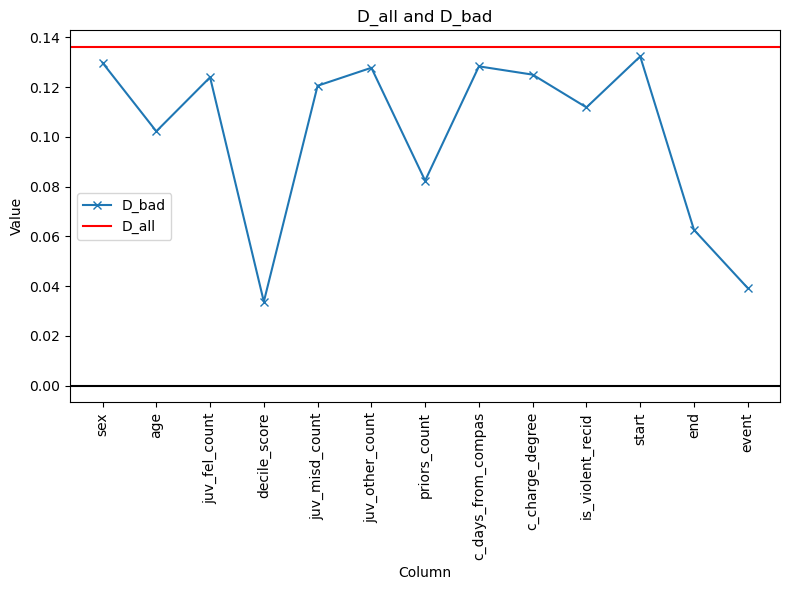

In [8]:
## Plot the graph of D_{all} and D_{bad}
def plot_D(D_bad, D_all):
  df_plot = pd.DataFrame({
      'Column': D_bad.keys(),
      'D_bad': D_bad.values()
  })
  plt.figure(figsize=(8, 6))

  # Plot D_{expl} and D_{all}
  plt.plot(df_plot['Column'], df_plot['D_bad'], marker='x', label='D_bad')
  plt.axhline(y=D_all, color='r', linestyle='-', label='D_all')
  plt.axhline(y=0, color='black', linestyle='-')
  plt.title('D_all and D_bad')
  plt.xlabel('Column')
  plt.ylabel('Value')
  plt.xticks(rotation=90)
  plt.legend()
  plt.tight_layout()
  plt.show()

plot_D(D_bad_baseline, D_all_base)

As we can see on the plot, `decile_score` have the highest $D_{expl}$ in absolute value. Hence, we will use `decile_score` as the explanatory attribute.

In [9]:
# define attributes
explanatory_attribute = 'decile_score'
sensitive_attribute = 'race'
target = 'two_year_recid'

## *Local Massaging*

We will use the same set of features when training the logistics regression model previously to calculate the closeness to the decision boundary to ensure consistency, so we could get valid results.

In [13]:
# Calculate the closeness to the decision boundary
def calculate_closeness(df, model, feature):
    scores = model.predict_proba(feature)[:, 1]
    closeness = np.abs(scores - 0.5)
    return closeness

In [19]:
# Define function for local massaging
def LocalMassaging(df, model, feature, sensitive_attr, explanatory_attr, target):
    
    df_massaged = df.copy() # avoid changing originial dataframe
    df_massaged['closeness'] = calculate_closeness(model, feature)
    
    # Calculate P*
    P_star = df_massaged.groupby(explanatory_attr)[target].mean().mean()
    
    # Calculate the acceptance rate for each group
    acceptance_rates = df_massaged.groupby([sensitive_attr, explanatory_attr])[target].mean()
    
    # For each group within the explanatory subset, adjust labels to match P*
    for (sens_value, expl_value), group_df in df_massaged.groupby([sensitive_attr, explanatory_attr]):
        
        # Calculate the number of labels that need to be changed
        current_rate = acceptance_rates[sens_value, expl_value]
        num_to_change = int(abs(current_rate - P_star) * len(group_df))
        
        if num_to_change == 0:
            continue
        
        # Sort the individuals based on closeness to decision boundary
        group_df_sorted = group_df.sort_values(by='closeness', ascending=False)
        group_indices = group_df_sorted.index
        
        if current_rate > P_star:
            # Change positive labels to negative for those closest to the decision boundary
            change_indices = group_df_sorted[group_df_sorted[target] == 1].head(num_to_change).index
            df_massaged.loc[change_indices, target] = 0
        else:
            change_indices = group_df_sorted[group_df_sorted[target] == 0].head(num_to_change).index
            df_massaged.loc[change_indices, target] = 1
    
    return df_massaged

/Users/helena/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


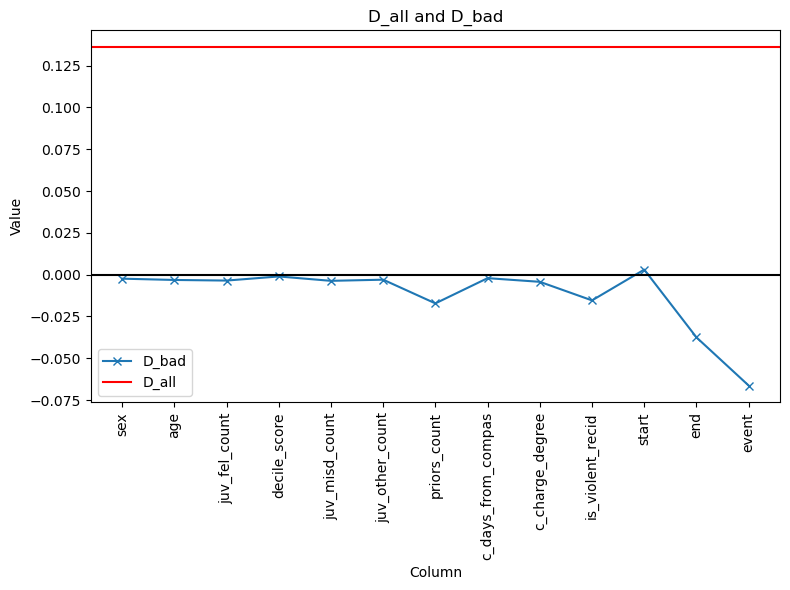

In [20]:
df_lm = LocalMassaging(df, baseline, X, sensitive_attribute, explanatory_attribute, target)
df_lm.drop("closeness", axis = 1, inplace = True)
D_all_lm = D_all_func(data = df_lm)
D_bad_lm = D_bad_func(data = df_lm, expl_col=expl, D_all = D_all_lm)
plot_D(D_bad_lm, D_all_base)

$D_{bad}$ decreased after we apply the algorithm. $D_{bad}$ for some of the columns are very close to zero.

In [21]:
D_bad_baseline

{'sex': 0.1297560180680939,
 'age': 0.10219820677211319,
 'juv_fel_count': 0.12392018319247723,
 'decile_score': 0.03373167631959474,
 'juv_misd_count': 0.12051902361576067,
 'juv_other_count': 0.12773893995781926,
 'priors_count': 0.08235300135829679,
 'c_days_from_compas': 0.1283114711643402,
 'c_charge_degree': 0.12497753421846196,
 'is_violent_recid': 0.11181364383115146,
 'start': 0.13230013716366482,
 'end': 0.06259516358852757,
 'event': 0.03917499502562369}

In [22]:
D_bad_lm

{'sex': -0.002400814473665455,
 'age': -0.0031672184079841507,
 'juv_fel_count': -0.0035340556353116487,
 'decile_score': -0.0010825092619428933,
 'juv_misd_count': -0.0036939126375648643,
 'juv_other_count': -0.003008028777077593,
 'priors_count': -0.017179256708454507,
 'c_days_from_compas': -0.002091877644339917,
 'c_charge_degree': -0.004286316019463651,
 'is_violent_recid': -0.015393739715913825,
 'start': 0.0030173702317535652,
 'end': -0.037502728952884895,
 'event': -0.06631996596181046}

Absolute value of `D_bad` decreased significantly compare to our baseline.

In [23]:
# Accuracy of local massaging
X_lm, y_lm = df_lm.drop("two_year_recid", axis = 1, inplace = False), df_lm.two_year_recid
X_lm = scaler.fit_transform(X_lm)

preds_all_lm = baseline.predict(X_lm)
accuracy_lm = sum(y_lm == preds_all_lm)/len(y_lm)

print("Baseline Accuracy: %f" % (accuracy_base))
print("Local Massaging Accuracy: %f" % (accuracy_lm))

Baseline Accuracy: 0.951904
Local Massaging Accuracy: 0.779916


In [24]:
# Accuracy of African-American
df_lm_AA = df_lm[df_lm['race'] == 1]
X_lm_AA, y_lm_AA = df_lm_AA.drop("two_year_recid", axis = 1, inplace = False), df_lm_AA.two_year_recid
X_lm_AA = scaler.fit_transform(X_lm_AA)

preds_lm_AA = baseline.predict(X_lm_AA)
accuracy_lm_AA = sum(y_lm_AA == preds_lm_AA)/len(y_lm_AA)

print("Local Massaging Accuracy of African-American: %f" % (accuracy_lm_AA))

Local Massaging Accuracy of African-American: 0.754754


In [25]:
# Accuracy of Caucasian
df_lm_C = df_lm[df_lm['race'] == 0]
X_lm_C, y_lm_C = df_lm_C.drop("two_year_recid", axis = 1, inplace = False), df_lm_C.two_year_recid
X_lm_C = scaler.fit_transform(X_lm_C)

preds_lm_C = baseline.predict(X_lm_C)
accuracy_lm_C = sum(y_lm_C == preds_lm_C)/len(y_lm_C)

print("Local Massaging Accuracy of Caucasian: %f" % (accuracy_lm_C))

Local Massaging Accuracy of Caucasian: 0.800885


## *Local preferential sampling*

In [26]:
def delta(partition_data, r):
  P_race_1 = partition_data[partition_data.race == 1].two_year_recid.mean()
  P_race_0 = partition_data[partition_data.race == 0].two_year_recid.mean()
  P_star = (P_race_1 + P_race_0) / 2
  P_race = partition_data[partition_data.race == r].two_year_recid.mean()
  G = len(partition_data[partition_data.race == r])
  delta_val = G * abs(P_star - P_race)
  return (delta_val)

In [27]:
def LocalPreferentialSampling(expl_str, data = df, drop_c = ["two_year_recid", "race"]):
  new_df = data.copy()
  for i in np.unique(new_df[expl_str]):
    partition = df[df[expl_str] == i].copy()
    for r in (0, 1):
      D = delta(partition, r)
      if D > 2:
        race = partition[partition['race'] == r].copy()
        X_race = race.drop(drop_c, axis = 1, inplace = False)
        X_race_scaled = scaler.fit_transform(X_race)
        ## Learn a ranker
        ranker = LogisticRegression(random_state=5243,max_iter=200)

        ranker.fit(X_race_scaled, race.two_year_recid)
        race['rank'] = ranker.predict_proba(X_race_scaled)[:, 1]

        ## we should increase the number of y = + to race = 1
        race_0 = race[race['two_year_recid'] == 0].sort_values(by='rank')
        race_1 = race[race['two_year_recid'] == 1].sort_values(by='rank')
        cloest_1_but_0 = race_0.head((int(1/2 * D))).drop(columns = 'rank')
        cloest_0_but_1 = race_1.tail((int(1/2 * D))).drop(columns = 'rank')
        if r == 0:
          new_df.drop(cloest_0_but_1.index, inplace = True)
          new_df = pd.concat([new_df, cloest_1_but_0], ignore_index=False)
        else:
          new_df.drop(cloest_1_but_0.index, inplace = True)
          new_df = pd.concat([new_df, cloest_0_but_1], ignore_index=False)
  return(new_df)

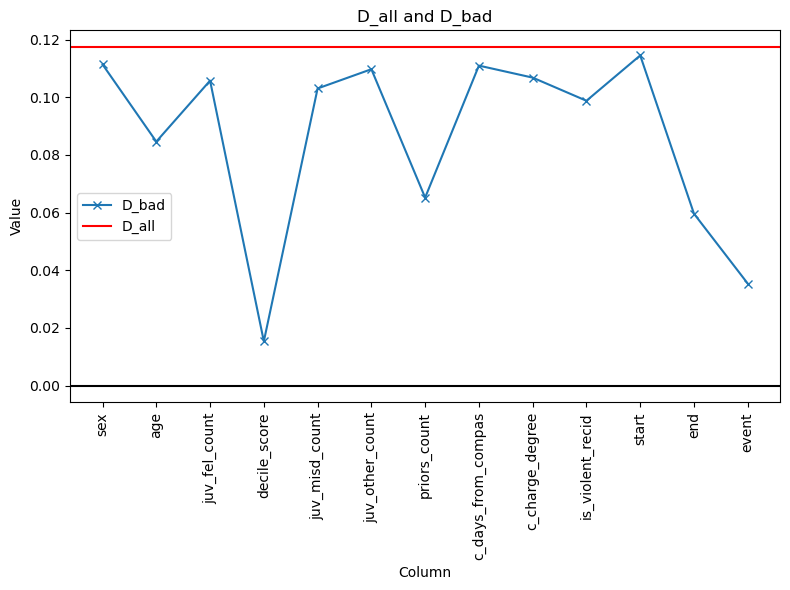

In [28]:
df_lps = LocalPreferentialSampling('decile_score', data = df,
                                   drop_c = ["two_year_recid", "race"])
D_all_lps = D_all_func(data = df_lps)
D_bad_lps = D_bad_func(data = df_lps, expl_col=expl, D_all = D_all_lps)
plot_D(D_bad_lps, D_all_lps)

As we can see from the plot, the $D_{bad}$ decrease after we apply the algorithm. However, the decreasing seems to be limited.

In [29]:
## Change in accuracy
X_lps, y_lps = df_lps.drop("two_year_recid", axis = 1, inplace = False), df_lps.two_year_recid
X_lps = scaler.fit_transform(X_lps)

preds_all_lps = baseline.predict(X_lps)
accuracy_lps = sum(y_lps == preds_all_lps)/len(y_lps)

print("Accuracy: %f" % (accuracy_base))
print("LPS Accuracy: %f" % (accuracy_lps))

Accuracy: 0.951904
LPS Accuracy: 0.932251


Meanwhile, the accuracy drop by a very small amount.